In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray
from tqdm.notebook import tqdm
import pointpats
import seaborn as sns
%matplotlib inline

#### Set directory

In [2]:
os.chdir("Data/")

### Importing dataset

In [3]:
dset = xarray.open_dataset('DATASETS/dset_AF_3.nc')
dset

<xarray.Dataset>
Dimensions:                (y: 1335, x: 1322)
Coordinates:
    lon                    (y, x) float64 ...
    lat                    (y, x) float64 ...
Dimensions without coordinates: y, x
Data variables: (12/14)
    TC                     (y, x) float64 ...
    Kperc                  (y, x) float64 ...
    eTh                    (y, x) float64 ...
    eU                     (y, x) float64 ...
    resmag                 (y, x) float64 ...
    asa                    (y, x) float64 ...
    ...                     ...
    litho_units            (y, x) object ...
    labels                 (y, x) float64 ...
    fav_lithos             (y, x) float64 ...
    dykes_buffer           (y, x) float64 ...
    lineam_ne_sw_proxim    (y, x) float64 ...
    lineam_wnw_ese_proxim  (y, x) float64 ...
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

#### Split area into training and test

In [4]:
ny, nx = dset.dims['y'], dset.dims['x']

In [5]:
lat_ths = -10.15
# filter locations where lat > ths
train_idk, train_idj = np.where(dset['lat'].data > lat_ths)
# filter locations where lat <= ths
test_idk, test_idj = np.where(dset['lat'].data <= lat_ths)

In [6]:
ny0, nx0 = np.unique(dset['lat'].data[train_idk, train_idj]).size, np.unique(dset['lon'].data[train_idk, train_idj]).size
print((ny0, nx0))
ny1, nx1 = np.unique(dset['lat'].data[test_idk, test_idj]).size, np.unique(dset['lon'].data[test_idk, test_idj]).size
print((ny1, nx1))

(581, 1322)
(754, 1322)


In [7]:
variables = [var for var in dset.data_vars]
print(variables)

['TC', 'Kperc', 'eTh', 'eU', 'resmag', 'asa', 'tilt', 'DTM', 'litho_units', 'labels', 'fav_lithos', 'dykes_buffer', 'lineam_ne_sw_proxim', 'lineam_wnw_ese_proxim']


#### Filter deposits and occurrences

In [8]:
cond = (dset['labels'].data == 1) | (dset['labels'].data == 2)

# positive locations' index
pk, pj = np.where(cond)

#### Point pattern analysis

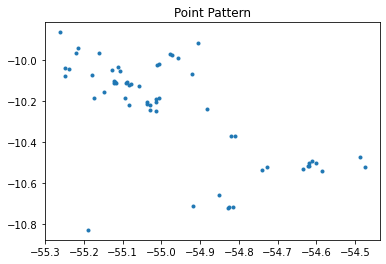

In [9]:
# positive locations' coordinates
p_lat, p_lon = dset['lat'].data[pk, pj], dset['lon'].data[pk, pj]

points = np.stack((p_lon, p_lat), axis=1)
pp = pointpats.PointPattern(points)
pp.plot()

[9.92491978] km


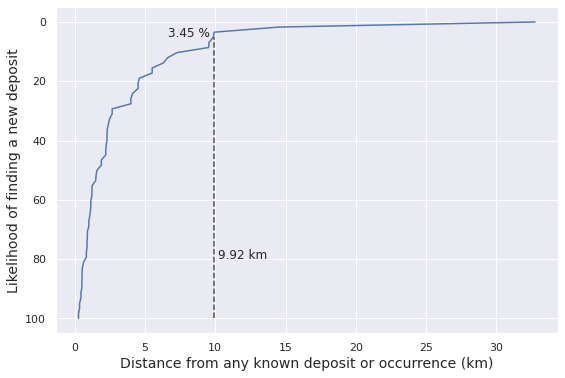

In [10]:
sns.set_theme()
distances = np.sort(pp.nnd*111, axis=0) # distances [km]
perc = np.linspace(0, 100, distances.size)[::-1]
# inflexion
infl = 56
print(distances[infl], 'km')

plt.figure(figsize=(9, 6), facecolor='w')

plt.plot(distances, perc, alpha=0.95)
plt.plot([distances[infl]]*len(perc[:infl]), perc[:infl], linestyle='--', color='.3')
#plt.scatter(distances[infl], perc[infl], color='.4')
plt.xlabel('Distance from any known deposit or occurrence (km)', fontsize=14)
plt.ylabel('Likelihood of finding a new deposit', fontsize=14)
plt.text(distances[infl]+0.3, 80, f'{distances[infl][0]:.2f} km')
plt.text(distances[infl]-3.3, perc[infl]+1.5, f'{perc[infl]:.2f} %')
plt.gca().invert_yaxis()
plt.savefig('figs/dep_prob_dists.png', dpi=400, bbox_inches='tight')
plt.show()

In [11]:
def calc_dist(ds, gdf, xdim='lon', ydim='lat', n=1000, set_random=True):

    import warnings
    from numpy.random import choice
    from numpy import concatenate
    from scipy.interpolate import griddata
    from scipy.spatial.distance import euclidean
    from tqdm.notebook import tqdm
    import time
    from sys import stdout
    warnings.simplefilter("ignore", UserWarning)
    
    tic = time.time()
    x = ds[xdim].data
    y = ds[ydim].data
    ny, nx = ds.dims['y'], ds.dims['x']
    print((ny, nx))
     

    if set_random:
        index = np.arange(0, y.size, 1, dtype=int)
        sy = sx = choice(index, size=int(n*.8), replace=False)
    
    else:
        sy = sx = np.arange(0, y.size, int(n*.8), dtype=int)
    
    yborder = np.linspace(0, ny-1, n//20, dtype=int)
    xborder = np.linspace(0, nx-1, n//20, dtype=int)
    xi = concatenate([x.ravel()[sx], x[0, :][xborder], x[-1, :][xborder],
                      x[:, 0][yborder], x[:,-1][yborder]])
    yi = concatenate([y.ravel()[sy], y[0, :][xborder], y[-1, :][xborder],
                      y[:, 0][yborder], y[:, -1][yborder]])
    
    # create buffer array
    buffer = np.empty(xi.size)
    
    # gdf x, y coordinates
    xp = gdf.geometry.x.values
    yp = gdf.geometry.y.values
    
    c = 0
    for x_i, y_i in zip(xi, yi):
        
        percentage = c/n
        time_msg = "\rRunning Progress at {0:.0%} ".format(percentage)
        stdout.write(time_msg)
        # store distances
        dist = []
        for x_p, y_p in zip(xp, yp):
    
            dist.append(euclidean((x_i, y_i), (x_p, y_p)))
        
        # add min distance to array
        buffer[c] = np.min(dist)
        c += 1
    
    # interp
    buffer = griddata((xi, yi), buffer, (x, y), method='linear')
    buffer = np.nan_to_num(buffer, nan=np.nanmean(buffer))
    toc = time.time()
    
    print(f'\n Processing Time: {(toc-tic)/60} min.')
    return buffer

In [12]:
from shapely import geometry
# EPSG:4674
crs = "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"

pos_gdf = pd.DataFrame({'lon':p_lon, 'lat':p_lat})
# create geodataframe
pos_gdf['geometry'] = gpd.points_from_xy(pos_gdf.lon, pos_gdf.lat)
pos_gdf = gpd.GeoDataFrame(pos_gdf, geometry='geometry', crs=crs)
pos_gdf.head()

,lon,lat,geometry
0,-55.189292,-10.828842,POINT (-55.18929 -10.82884)
1,-54.827774,-10.719615,POINT (-54.82777 -10.71961)
2,-54.824395,-10.717363,POINT (-54.82440 -10.71736)
3,-54.814259,-10.717363,POINT (-54.81426 -10.71736)
4,-54.918998,-10.710607,POINT (-54.91900 -10.71061)


In [13]:
buffer_pos = calc_dist(dset, pos_gdf, n=50000)*111

(1335, 1322)
Running Progress at 100% 
 Processing Time: 0.24456894795099896 min.


In [14]:
dset['pos_locations_buffer'] =  (['y', 'x'], buffer_pos, {'variable':'Proximity to positive locations', 'unit':'km'})
dset

<xarray.Dataset>
Dimensions:                (y: 1335, x: 1322)
Coordinates:
    lon                    (y, x) float64 -55.49 -55.49 -55.49 ... -54.0 -54.0
    lat                    (y, x) float64 -11.0 -11.0 -11.0 ... -9.497 -9.497
Dimensions without coordinates: y, x
Data variables: (12/15)
    TC                     (y, x) float64 ...
    Kperc                  (y, x) float64 ...
    eTh                    (y, x) float64 ...
    eU                     (y, x) float64 ...
    resmag                 (y, x) float64 ...
    asa                    (y, x) float64 ...
    ...                     ...
    labels                 (y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fav_lithos             (y, x) float64 ...
    dykes_buffer           (y, x) float64 ...
    lineam_ne_sw_proxim    (y, x) float64 ...
    lineam_wnw_ese_proxim  (y, x) float64 ...
    pos_locations_buffer   (y, x) float64 38.24 38.13 38.02 ... 110.3 110.5
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

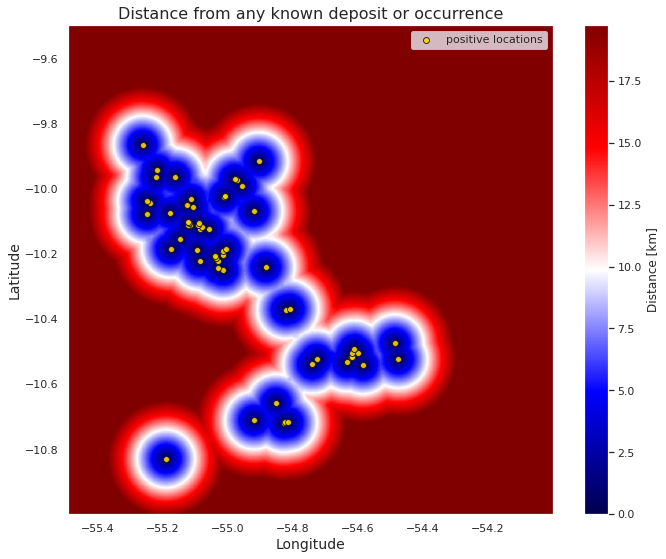

In [15]:
plt.rcParams['axes.grid'] = False
fig, ax = plt.subplots(figsize=(11, 9))
cat = np.where(dset['pos_locations_buffer'].data < distances[infl][0], 1, 0)
im = ax.pcolormesh(dset['lon'].data, dset['lat'].data, dset['pos_locations_buffer'].data,
                   shading='auto', cmap='seismic', vmin=0., vmax=np.max(distances)-13)
pos_gdf.plot(ax=ax, color='gold', edgecolor='k', alpha=0.9, label='positive locations')
plt.colorbar(im, ax=ax, label='Distance [km]')
ax.set_title('Distance from any known deposit or occurrence', fontsize=16)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_aspect(1)
plt.legend()
plt.savefig('figs/pos_buffer_map.png', dpi=400, bbox_inches='tight')
plt.show()

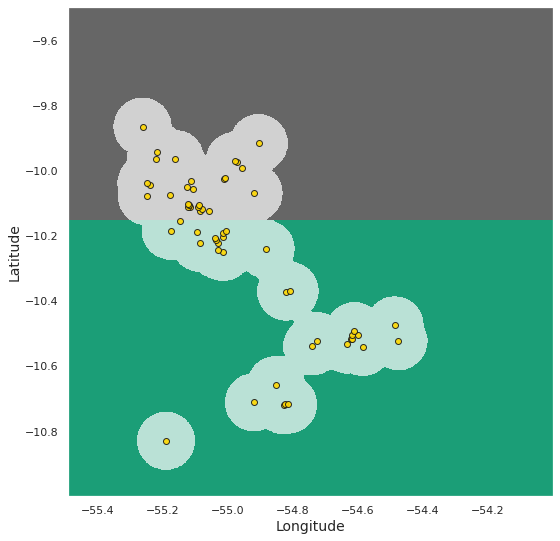

In [16]:
fig, ax = plt.subplots(figsize=(9, 9))
train_test_area = np.where(dset['lat'].data > lat_ths, 1, 0)
cat = np.where(dset['pos_locations_buffer'].data < distances[infl][0], 1, np.nan)
im = ax.pcolormesh(dset['lon'].data, dset['lat'].data, train_test_area,
                   shading='auto', cmap='Dark2')
im = ax.pcolormesh(dset['lon'].data, dset['lat'].data, cat,
                   shading='auto', cmap='Greys', alpha=0.7)
pos_gdf.plot(ax=ax, color='gold', edgecolor='k', alpha=0.9, label='positive locations')
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_aspect(1)
#plt.legend()
plt.savefig('figs/train_test_areas.png', dpi=400, bbox_inches='tight')
# plt.savefig('figs/train_test_areas.svg', format='svg', dpi=400, bbox_inches='tight')
plt.show()

### Use litho-classes to select negative examples

In [17]:
lithos = gpd.read_file('Juruena_Teles_Pires_Mapa_Integrado/Litologia/Juruena_Teles_Pires_Lito.shp')
crs = "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"
lithos.to_crs(crs, inplace=True)
lithos.head(3)

,COD_UNI_ES,SIGLA_UNID,NOME_UNIDA,SIGLAS_ANT,HIERARQUIA,IDADE_MAX,ERRO_MAX,EON_IDAD_M,ERA_MAXIMA,PERIODO_MA,...,ERRO_PRESS,TIPO_BARIC,TRAJETORIA,LITOTIPO1,LITOTIPO2,CLASSE_ROC,CLASSE_R_1,BB_SUBCLAS,BB_SUBCL_1,geometry
0,3207,MP2d2,Dardanelos - Fácies 2,None,Fácies,1400.0,0.0,Proterozóico,Mesoproterozóico,Ectasiano,...,None,None,None,None,"Arenito arcoseano, Arenito",None,Sedimentar,None,Clástica,"POLYGON ((-55.07166 -11.00000, -55.07169 -11.0..."
1,643,N1r,Ronuro,N1a,Formação,23.5,0.0,Fanerozóico,Cenozóico,Neogeno,...,None,None,None,None,"Cascalho, Argila, Areia",None,Material superficial,None,Sedimento inconsolidado,"POLYGON ((-54.23781 -10.72836, -54.23924 -10.7..."
2,1360,PP34mvbm,Complexo Nova Monte Verde - Unidade Bacaeri-Mogno,PP23bm,Unidade,2240.0,0.0,Proterozóico,Paleoproterozóico,Orosiriano,...,0,Média P/T,Não determinada,None,"Metachert, Paragnaisse, Rocha calcissilicática...",None,Metamórfica,None,Metamorfismo regional,"POLYGON ((-56.91694 -9.87497, -56.91692 -9.875..."


In [18]:
# check unique rock classes
classes = lithos.CLASSE_R_1.unique()
print(classes)

['Sedimentar' 'Material superficial' 'Metamórfica' 'Ígnea'
 'Metamórfica, Ígnea' 'Sedimentar, Ígnea' None
 'Material superficial, Sedimentar']


In [19]:
c1 = (lithos.CLASSE_R_1.values == 'Sedimentar')
c2 = (lithos.CLASSE_R_1.values == 'Material superficial') 
c3 = (lithos.CLASSE_R_1.values == 'Material superficial, Sedimentar')
lithos['rock_classes'] = np.where((c1 | c2 | c3), 1, 0)
lithos.head()

,COD_UNI_ES,SIGLA_UNID,NOME_UNIDA,SIGLAS_ANT,HIERARQUIA,IDADE_MAX,ERRO_MAX,EON_IDAD_M,ERA_MAXIMA,PERIODO_MA,...,TIPO_BARIC,TRAJETORIA,LITOTIPO1,LITOTIPO2,CLASSE_ROC,CLASSE_R_1,BB_SUBCLAS,BB_SUBCL_1,geometry,rock_classes
0,3207,MP2d2,Dardanelos - Fácies 2,None,Fácies,1400.0,0.0,Proterozóico,Mesoproterozóico,Ectasiano,...,None,None,None,"Arenito arcoseano, Arenito",None,Sedimentar,None,Clástica,"POLYGON ((-55.07166 -11.00000, -55.07169 -11.0...",1
1,643,N1r,Ronuro,N1a,Formação,23.5,0.0,Fanerozóico,Cenozóico,Neogeno,...,None,None,None,"Cascalho, Argila, Areia",None,Material superficial,None,Sedimento inconsolidado,"POLYGON ((-54.23781 -10.72836, -54.23924 -10.7...",1
2,1360,PP34mvbm,Complexo Nova Monte Verde - Unidade Bacaeri-Mogno,PP23bm,Unidade,2240.0,0.0,Proterozóico,Paleoproterozóico,Orosiriano,...,Média P/T,Não determinada,None,"Metachert, Paragnaisse, Rocha calcissilicática...",None,Metamórfica,None,Metamorfismo regional,"POLYGON ((-56.91694 -9.87497, -56.91692 -9.875...",0
3,2977,PP34mvvpe,Complexo Nova Monte Verde - Unidade Vila Progr...,PP23bm(end),Fácies,2243.0,0.0,Proterozóico,Paleoproterozóico,Orosiriano,...,Não determinado,Não determinada,None,"Quartzo diorito, Enderbito",None,Ígnea,None,Plutônica,"POLYGON ((-56.63942 -9.98401, -56.64000 -9.985...",0
4,2970,PP34mvvpa,Complexo Nova Monte Verde - Unidade Vila Progr...,PP23bm(af),Fácies,2240.0,0.0,Proterozóico,Paleoproterozóico,Orosiriano,...,None,None,None,"Metapiroxenito, Metanorito, Metagabro",None,Metamórfica,None,Metamorfismo regional,"POLYGON ((-56.86034 -9.98801, -56.86029 -9.988...",0


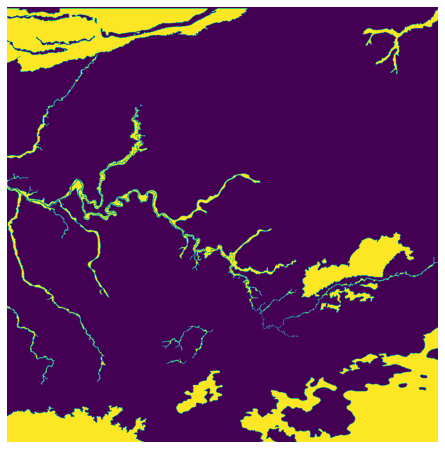

In [20]:
import rasterio
src = rasterio.open('RASTERS/rock_classes.tif')
rock_classes = src.read(1)
plt.figure(figsize=(8, 8))
plt.imshow(rock_classes, cmap='viridis', aspect=1)
plt.axis('off')
plt.show()

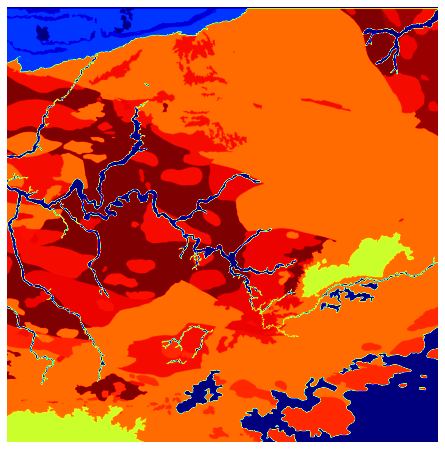

In [21]:
import rasterio
src = rasterio.open('RASTERS/idade_min.tif')
idade_min = src.read(1)
idade_min = np.where(idade_min == np.nan, 0, idade_min)
plt.figure(figsize=(8, 8))
plt.imshow(idade_min, cmap='jet', aspect=1)
plt.axis('off')
plt.show()

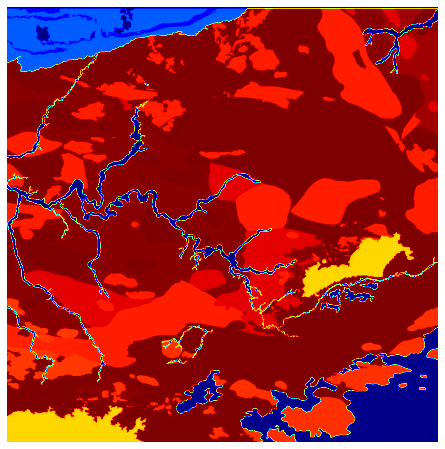

In [22]:
import rasterio
src = rasterio.open('RASTERS/idade_max.tif')
idade_max = src.read(1)
idade_max = np.where(idade_max == np.nan, 0, idade_max)
plt.figure(figsize=(8, 8))
plt.imshow(idade_max, cmap='jet', aspect=1)
plt.axis('off')
plt.show()

In [23]:
dset['litho_classes'] =  (['y', 'x'], np.flip(rock_classes, axis=0),
                                             {'0':'Not Sedimentary', '1':'Sedimentary'})
dset['idade_min'] =  (['y', 'x'], np.flip(idade_min, axis=0),
                                             {'unit':'Ma'})
dset['idade_max'] =  (['y', 'x'], np.flip(idade_max, axis=0),
                                             {'unit':'Ma'})
dset

<xarray.Dataset>
Dimensions:                (y: 1335, x: 1322)
Coordinates:
    lon                    (y, x) float64 -55.49 -55.49 -55.49 ... -54.0 -54.0
    lat                    (y, x) float64 -11.0 -11.0 -11.0 ... -9.497 -9.497
Dimensions without coordinates: y, x
Data variables: (12/18)
    TC                     (y, x) float64 ...
    Kperc                  (y, x) float64 ...
    eTh                    (y, x) float64 ...
    eU                     (y, x) float64 ...
    resmag                 (y, x) float64 ...
    asa                    (y, x) float64 ...
    ...                     ...
    lineam_ne_sw_proxim    (y, x) float64 ...
    lineam_wnw_ese_proxim  (y, x) float64 ...
    pos_locations_buffer   (y, x) float64 38.24 38.13 38.02 ... 110.3 110.5
    litho_classes          (y, x) float32 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    idade_min              (y, x) float32 1.201e+03 1.201e+03 ... 0.0 0.0
    idade_max              (y, x) float32 1.4e+03 1.4e+03 1.4e+03 ... 0.0 0.0
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

In [24]:
print('K min:', dset['Kperc'].data.min(), 'Th min:', dset['eTh'].data.min(), 'U min:', dset['eU'].data.min())

K min: -0.712264992389143 Th min: -2.4308982547122455 U min: -2.477627723767782


In [25]:
dset['Th_K'] =  (['y', 'x'], (dset['eTh'].data + 2.5)/(dset['Kperc'].data + 2.5),
                  {'variable':'eTh-Kperc ratio', 'unit':'dimensionless'})
dset['U_K'] = (['y', 'x'], (dset['eU'].data + 2.5)/(dset['Kperc'].data + 2.5),
                  {'variable':'eU-Kperc ratio', 'unit':'dimensionless'})
dset

<xarray.Dataset>
Dimensions:                (y: 1335, x: 1322)
Coordinates:
    lon                    (y, x) float64 -55.49 -55.49 -55.49 ... -54.0 -54.0
    lat                    (y, x) float64 -11.0 -11.0 -11.0 ... -9.497 -9.497
Dimensions without coordinates: y, x
Data variables: (12/20)
    TC                     (y, x) float64 ...
    Kperc                  (y, x) float64 0.3964 0.3964 0.3964 ... 0.5725 0.5287
    eTh                    (y, x) float64 2.669 2.669 2.669 ... 5.193 5.544
    eU                     (y, x) float64 6.307 6.307 6.307 ... 20.07 19.75
    resmag                 (y, x) float64 ...
    asa                    (y, x) float64 ...
    ...                     ...
    pos_locations_buffer   (y, x) float64 38.24 38.13 38.02 ... 110.3 110.5
    litho_classes          (y, x) float32 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    idade_min              (y, x) float32 1.201e+03 1.201e+03 ... 0.0 0.0
    idade_max              (y, x) float32 1.4e+03 1.4e+03 1.4e+03 ... 0.0 0.0
    Th_K                   (y, x) float64 1.785 1.785 1.785 ... 2.504 2.656
    U_K                    (y, x) float64 3.041 3.041 3.041 ... 7.346 7.345
Attributes:
    description:  Geoscientific data from Alta Floresta, MT, Brazil.

In [26]:
#save dataset to netcdf
dset.to_netcdf(path='DATASETS/dset_AF_4.nc', mode='w', format='NETCDF4')